<a href="https://colab.research.google.com/github/SujayVivek/MLSP-Lab-8th-Sem-2026/blob/main/exp2SPML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

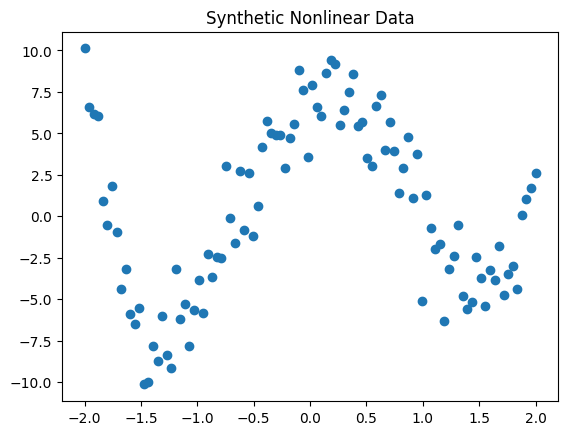

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic data (Section 7.1)
def generate_data(m=100):
    x = np.linspace(-2, 2, m)
    # Target function: f(x) = 3x(x-1)(x-1.9)(x+0.7)(x+1.8)
    y_true = 3 * (x - 1) * (x - 1.9) * (x + 0.7) * (x + 1.8)
    # Add Gaussian noise v(n) ~ N(0, sigma^2)
    noise = np.random.normal(0, 2, m)

    y = y_true + noise
    return x, y

x, y = generate_data(100)
plt.scatter(x, y, label='Data with Noise')
plt.title("Synthetic Nonlinear Data")
plt.show()

In [29]:
# 1. Train-Test Split (Section 3)
m = len(x)
indices = np.arange(m)
np.random.shuffle(indices)
train_size = int(0.8 * m)

train_idx, test_idx = indices[:train_size], indices[train_size:]
x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = x[test_idx], y[test_idx]

# 2. Feature Scaling: Standardization (Section 2)
def standardize(data):
    mu = np.mean(data)
    sigma = np.std(data)
    return (data - mu) / sigma, mu, sigma

x_train_scaled, x_mean, x_std = standardize(x_train)
# Use training mean/std to scale test data to prevent leakage
x_test_scaled = (x_test - x_mean) / x_std

print(f"Training samples: {len(x_train_scaled)}, Test samples: {len(x_test_scaled)}")

Training samples: 80, Test samples: 20


In [33]:
def get_polynomial_features(x, degree):
    m = x.shape[0]
    # Matrix X = [1, x, x^2, ..., x^N]
    X = np.ones((m, degree + 1))
    for j in range(1, degree + 1):
        X[:, j] = x**j
    return X

degree = 5 # Example degree
X_train = get_polynomial_features(x_train_scaled, degree)
X_test = get_polynomial_features(x_test_scaled, degree)

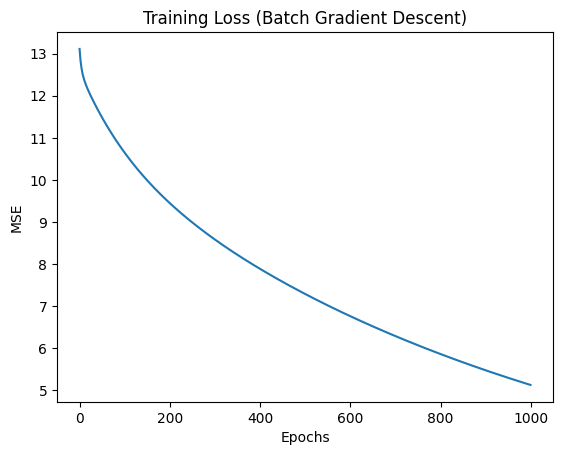

In [34]:
def batch_gradient_descent(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for _ in range(epochs):
        # Prediction: y_hat = X * theta
        y_hat = np.dot(X, theta)
        # Error
        error = y_hat - y
        # MSE Cost: J = (1/2m) * sum(error^2)
        cost = (1 / (2 * m)) * np.sum(error**2)
        cost_history.append(cost)
        # Vectorized Update Rule: theta = theta - alpha * (1/m) * X.T * (X*theta - y)
        gradient = (1 / m) * np.dot(X.T, error)
        theta = theta - lr * gradient

    return theta, cost_history

theta_bgd, loss_bgd = batch_gradient_descent(X_train, y_train)

plt.plot(loss_bgd)
plt.title("Training Loss (Batch Gradient Descent)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

Least Mean Squared

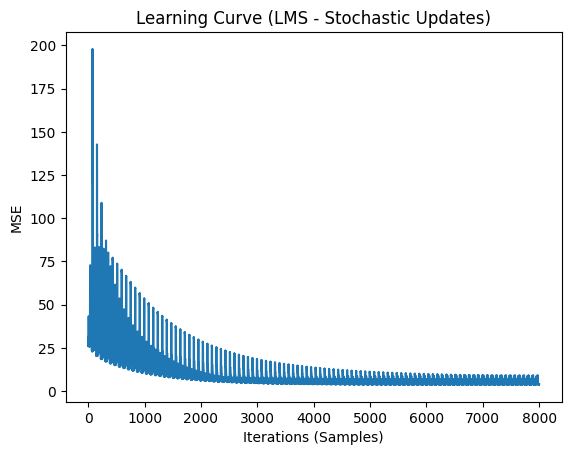

In [40]:
def lms_algorithm(X, y, step_size=0.01, epochs=10):
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for epoch in range(epochs):
        for i in range(m):
            # Instantaneous feature vector phi(n)
            phi_n = X[i, :]
            # Instantaneous prediction
            y_hat_n = np.dot(phi_n, theta)
            # Instantaneous Error: e(n) = y(n) - y_hat(n)
            error_n = y[i] - y_hat_n
            # LMS Update: theta(n+1) = theta(n) + mu * e(n) * phi(n)
            theta = theta + step_size * error_n * phi_n

            # Record MSE for plotting
            current_mse = np.mean((np.dot(X, theta) - y)**2)
            cost_history.append(current_mse)

    return theta, cost_history

theta_lms, loss_lms = lms_algorithm(X_train, y_train, step_size=0.01, epochs=100)

plt.plot(loss_lms)
plt.title("Learning Curve (LMS - Stochastic Updates)")
plt.xlabel("Iterations (Samples)")
plt.ylabel("MSE")
plt.show()

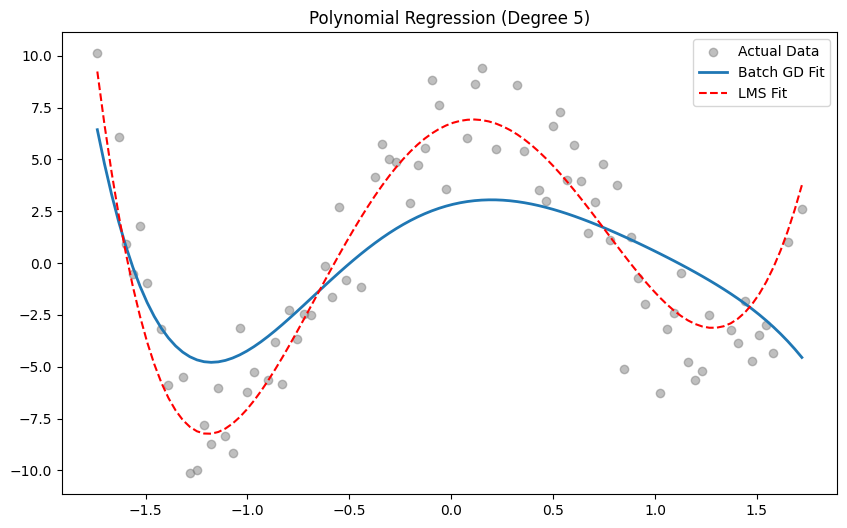

In [41]:
# Sort for plotting smooth lines
plot_x = np.linspace(min(x_train_scaled), max(x_train_scaled), 100)
X_plot = get_polynomial_features(plot_x, degree)

# Predictions
y_plot_bgd = np.dot(X_plot, theta_bgd)
y_plot_lms = np.dot(X_plot, theta_lms)

plt.figure(figsize=(10, 6))
plt.scatter(x_train_scaled, y_train, color='gray', alpha=0.5, label='Actual Data')
plt.plot(plot_x, y_plot_bgd, label='Batch GD Fit', linewidth=2)
plt.plot(plot_x, y_plot_lms, label='LMS Fit', linestyle='--', color='red')
plt.legend()
plt.title(f"Polynomial Regression (Degree {degree})")
plt.show()

# Conclusion: LMS vs Batch GD (Section 7.6)
# Observe that LMS converges faster initially but exhibits fluctuations due to noisy updates.

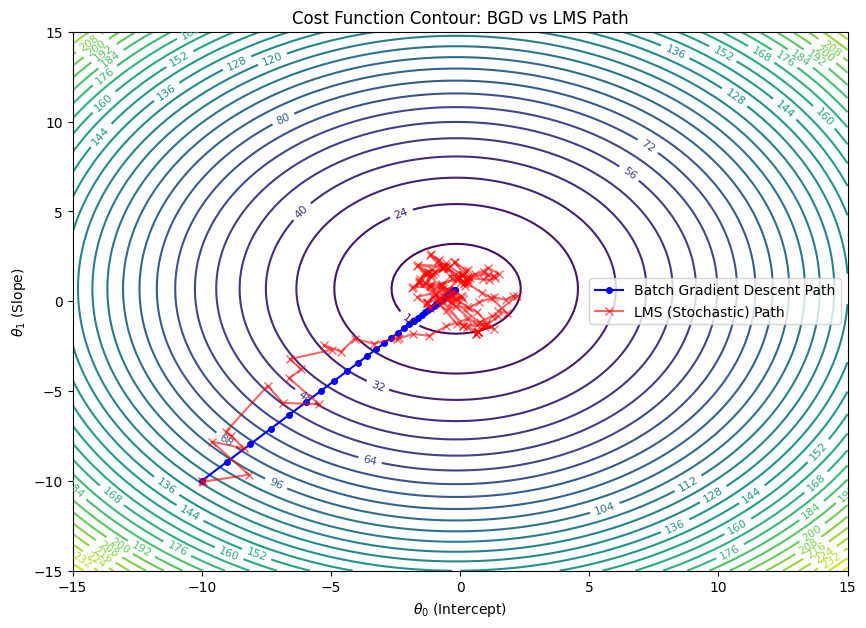

In [37]:
# 1. Prepare data for a 1st degree polynomial (Linear Regression)
degree_contour = 1
X_contour = get_polynomial_features(x_train_scaled, degree_contour)

# 2. Run Batch Gradient Descent and track parameter history
def bgd_with_path(X, y, lr=0.1, epochs=50):
    m, n = X.shape
    theta = np.array([-10.0, -10.0]) # Starting point
    path = [theta.copy()]
    for _ in range(epochs):
        error = np.dot(X, theta) - y
        gradient = (1/m) * np.dot(X.T, error)
        theta = theta - lr * gradient
        path.append(theta.copy())
    return np.array(path)

# 3. Run LMS and track parameter history
def lms_with_path(X, y, step_size=0.1, epochs=2):
    m, n = X.shape
    theta = np.array([-10.0, -10.0]) # Same starting point
    path = [theta.copy()]
    for _ in range(epochs):
        for i in range(m):
            phi_n = X[i, :]
            error_n = y[i] - np.dot(phi_n, theta)
            theta = theta + step_size * error_n * phi_n
            path.append(theta.copy())
    return np.array(path)

path_bgd = bgd_with_path(X_contour, y_train)
path_lms = lms_with_path(X_contour, y_train)

# 4. Generate Cost Surface Grid
t0_range = np.linspace(-15, 15, 100)
t1_range = np.linspace(-15, 15, 100)
T0, T1 = np.meshgrid(t0_range, t1_range)
Z = np.zeros(T0.shape)

for i in range(len(t0_range)):
    for j in range(len(t1_range)):
        temp_theta = np.array([T0[i,j], T1[i,j]])
        Z[i,j] = (1/(2*len(y_train))) * np.sum((np.dot(X_contour, temp_theta) - y_train)**2)

# 5. Plotting
plt.figure(figsize=(10, 7))
cp = plt.contour(T0, T1, Z, levels=30, cmap='viridis')
plt.clabel(cp, inline=True, fontsize=8)

plt.plot(path_bgd[:,0], path_bgd[:,1], 'b-o', label='Batch Gradient Descent Path', markersize=4)
plt.plot(path_lms[:,0], path_lms[:,1], 'r-x', label='LMS (Stochastic) Path', alpha=0.6)

plt.xlabel(r'$\theta_0$ (Intercept)')
plt.ylabel(r'$\theta_1$ (Slope)')
plt.title('Cost Function Contour: BGD vs LMS Path')
plt.legend()
plt.show()

Lab Manual Part Experiement: